<div class="alert alert-block alert-success" style="text-align:center;">
Formation Data Scientist - Projet n°7 - OpenClassrooms - Christoph Pruvost - avril/mai 2022

<center><a href="https://openclassrooms.com/fr/paths/164/projects/632/assignment">https://openclassrooms.com/fr/paths/164/projects/632/assignment</a></center>
<!-- <p></p>
<ul class="last simple">
<li></li> -->
</div>

# Implémentez un modèle de scoring
<div class="admonition note alert alert-info">
    <p class="first admonition-title" style="font-size:25px;font-weight: bold;text-align:center;">Modélisation ⚙️</p>
<p class="last">&nbsp;
<p>Nous sommes Data Scientist au sein d'une société financière, nommée <strong>"Prêt à dépenser"</strong>, &nbsp;qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.</p>

<p>L’entreprise souhaite <strong>mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité </strong>qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un <strong>algorithme de classification</strong> en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).</p>
<p>De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de <strong>transparence</strong> vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.</p>
<p><strong>Prêt à dépenser </strong>décide donc de <strong>développer un dashboard interactif</strong> pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.</p>
<br><u><b>Les données</b></u>
<p><a href="https://www.kaggle.com/c/home-credit-default-risk/data">Voici les données</a> dont nous aurons besoin pour réaliser le dashboard. Pour plus de simplicité, nous pouvons également les télécharger à <a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip">cette adresse</a>.</p>
<br><u><b>Notre mission</b></u>
<ol>
<li>Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.</li>
<li>Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.</li>
</ol>
<p><strong>Michaël</strong>, notre manager, nous incite à sélectionner un kernel Kaggle pour nous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Nous analyserons ce kernel et l’adapterons pour nous assurer qu’il répond aux besoins de votre mission. Nous pourrons ainsi nous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.</p>
&nbsp;
<p>Nous allons réaliser ici la <strong>modélisation des données</strong>.&nbsp;
</p>
</div>

*La modélisation s'appuie sur le kernel Kaggle suivant :* https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script


## Imports et variables
Importons les librairies nécessaires à notre analyse et définissons quelques variables globales.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime, time, sys, os
from contextlib import contextmanager
import gc
import re
import sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,\
                            confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay, average_precision_score,\
                            ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from collections import Counter
import joblib

In [2]:
# Versions des librairies utilisées :
print('Version des librairies utilisées le', datetime.datetime.now(), '\n',
       'Python :', sys.version, '\n',
       'NumPy :',  np.version.full_version, '\n',
       'Pandas :', pd.__version__, '\n',
       'Matplotlib :', mpl.__version__, '\n',
       'Seaborn :', sns.__version__, '\n',
       'sklearn :', sklearn.__version__
      )

Version des librairies utilisées le 2022-06-13 13:03:03.015955 
 Python : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:38:57) [GCC 10.3.0] 
 NumPy : 1.22.3 
 Pandas : 1.4.2 
 Matplotlib : 3.5.2 
 Seaborn : 0.11.2 
 sklearn : 1.0.2


In [3]:
# Appliquons certaines options globales Pandas et seaborn :
pandas_options = {
    'display.max_rows': 400,
    'display.max_column': 50,
    'display.width': 100,
    'display.max_colwidth': 2000,  # 200
    'display.float_format': '{:,.2f}'.format # arrondi à 2 chiffres après la virgule
}

for cle, valeur in pandas_options.items():
    pd.set_option(cle, valeur)

# Agrandissons les polices d'écriture par défaut :
# sns.set(font_scale=1.1)
# Graphiques avec fond blanc :
# sns.set_style("white")

In [4]:
# Variables
random_state = 82
data_dir = '.data'
fichier_donnees_pretraitees = "donnees_pretraitees.ftr"
modele_prod = 'modele_api.joblib'
donnees_prod = 'data_prod.ftr' # données destinées à l'API pour l'affichage des données et prédictions.
clients_pred_defaut = 'data_prod_pred_TARGET_1.ftr' # liste des clients prédits en defaut, pour le test du tableau de bord

## Chargement des données
Chargeons les données prétraitées précédemment et séparons-les données d'entraînement des données de test. Nous ne conservons que les données utiles à l'entraînement, c'est à dire celles où nous avons la valeur cible.

In [5]:
df = pd.read_feather(os.path.join(data_dir, fichier_donnees_pretraitees))
print("Taille du DataFrame avec les données d'entraînement et de test :\n", df.shape)

df = df[df['TARGET'].notna()]
print("Taille du DataFrame avec uniquement les données d'entraînement :\n", df.shape)

FileNotFoundError: [Errno 2] No such file or directory: '.data/donnees_pretraitees.ftr'

In [ ]:
df.head()

## Préparation du jeu de données

### Échantillonnage
Au cours de la modélisation il s'est avéré qu'en raison de la quantité d'informations, certains modèles nécessitaient 20 à 60min pour une validation croisée. Il a donc été décidé de travailler sur une fraction des données, afin d'accélérer la phase de recherche du meilleur modèle.

Observons la quantité d'individus initiale et sa répartition en fonction de la variable à déterminer.

In [ ]:
def graph_repartition(data):
    """
    Fonction de visualisation de la répartition des classes de la variable cible.
    Parameters:
    ----------
    -data : Series correspondant à la variable cible (df['TARGET']).
    
    Returns:
    None
    """
    repartition = data.value_counts()
    display(pd.DataFrame({'Individus': repartition, '% du total':repartition*100/data.shape[0]}))
    # Visualisation de la variable cible :
    g = sns.countplot(x=data)
    g.set_xticklabels(['Bon payeur','Mauvais payeur'])
    plt.ylabel("Nombre d'individus")
    plt.title(f'Répartition des classes de la variable {data.name}', fontsize=15)
    plt.show()

In [ ]:
# Observons la répartition dans df :
graph_repartition(df['TARGET'])

In [ ]:
df_fraction = df.copy()

In [ ]:
# Prenons un échantillon de 20% des données initiales :
df_fraction = df_fraction.sample(frac=0.2, random_state=random_state)

In [ ]:
# Vérifions que la répartition des données de variable cible est toujours la même dans notre échantillon :
grcaph_repartition(df_fraction['TARGET'])

### Colonnes à conserver

In [ ]:
var_non_predictives = ["index", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "TARGET"] 
var_predictives = [col for col in df.columns if col not in var_non_predictives]

X = df_fraction[var_predictives]
y = df_fraction['TARGET']

### Données d'entraînement et de test
Séparation du jeu de données avec les valeurs cibles, en un jeu de données d'entraînement des modèles et un jeu de données de test.

Le jeu de données d'entraînement pourra être reéchantillonné par différentes méthodes lors d'une phase d'équilibrage de la valeur cible, tandis que le jeu de données de test sera conservé tel quel pour pouvoir noter les capacités de généralisation des modèles sur des données nouvelles et réelles.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)
print(f"X : {X.shape}\ny : {y.shape}")
print('─'*50)
print(f"X_train : {X_train.shape}\ny_train : {y_train.shape}")
print('─'*50)
print(f"X_test : {X_test.shape}\ny_test : {y_test.shape}")

### Validation croisée
Nos validations croisées se feront avec `StratifiedKFold` de façon à préserver le pourcentage d'échantillons de chaque classe à travers les différents plis. Nous évitons ainsi le risque d'avoir des plis où la classe minoritaire serait absente du jeu de données d'apprentissage, empêchant ainsi le modèle d'en tenir compte.

In [ ]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

## Métriques d'évaluation
Quelles métriques utiliser pour évaluer nos modèles sur ce jeu de données ? Nous cherchons à minimiser les chances de pertes pour notre entreprise et maximiser les bénéfices.
Dans le cadre de la problématique de classification étudiée ici, nous pouvons avoir les 4 cas de figures du tableau ci-dessous :

|  |   |  | |
|--------------|:-----|:----------:|:---:|
|                       | **Classe prédite** | bon payeur (0) | mauvais payeur (1) |
| **Classe réelle**     |                    |                |                    |
| bon payeur (0)        |                    | Bon payeur<br>**TN**<br>*Vrai négatif*| Mauvais payeur, à tort<br>**FP**<br>*Faux positif*|
| mauvais payeur (1) |  | Bon payeur, à tort<br>**FN**<br>*Faux négatif*| Mauvais payeur<br>**TP**<br>*Vrai positif*|

Une classification à **1** désigne un dossier client en défaut de paiement, tandis qu'une classification à **0** désigne un dossier client sans incident.

En cas de classification erronnée, deux cas de figures impliquent des pertes pour notre entreprise, les **faux positifs** et les **faux négatifs**.
- **un faux positif**, signifie que le modèle a identifié à tort un client comme mauvais payeur. Le client aurait bien remboursé son crédit si sa demande avait été accordée. Mais comme sa demande est refusée, notre société se prive des intérêts que le prêt aurait généré.
- **un faux négatif**, signifie que le modèle a identifié à tort un client comme bon payeur. Le client en défaut de remboursement de son prêt entraîne donc la perte de tout ou partie des sommes engagées par notre société.

Les intérêts demandés par notre société en échange d'un prêt ne représentent généralement qu'une fraction du prêt. On comprend alors qu'un **faux négatif**, c-à-d. un client qui ne rembourse pas son prêt, est bien plus préjudiciable à notre société qu'un **faux positif**, c-à-d. un client qui ne rapportera pas d'intérêts à la banque en remboursant son prêt.

Nous allons donc privilégier les métriques qui nous permettent de sélectionner un modèle où les individus sont bien classifiés et les faux négatifs et faux positifs minimisés, avec une priorité donnée à la minimisation des faux négatifs.

![https://transparint.com/blog/wp-content/uploads/2016/03/false-positives.png](https://transparint.com/blog/wp-content/uploads/2016/03/false-positives.png)

*L'image ci-dessus est tirée de : https://transparint.com/blog/wp-content/uploads/2016/03/false-positives.png*

*Les informations en anglais ci-dessous concernant les métriques et le rééquilibrage de classes sont en grande partie tirées de : https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4*


### Exactitude

$Accuracy =  \frac{TP\,+\,TN}{TP\,+\,TN\,+\,FP\,+\,FN}$ 

Although it is the most widely-used and interpretable metric for classification problems, please do not make the rookie mistake of using the Accuracy metric to evaluate your classification model in case of imbalanced datasets.

Consider a highly skewed dataset with 1:100 class imbalance — for each instance of minority class (positive), there are 100 samples of the majority class (negative). A naive classifier (or, even a human being) can achieve a 99% prediction accuracy by predicting the majority class by default for each and every test sample, without any actual machine learning involved. However, this does not paint the true picture as may be correctly predicting the minority class is more contextually critical, e.g., in fraud detection or spam filtering algorithms.

### Précision

$Precision =  \frac{TP}{TP\:+\,FP}$

Precision is the ratio of true positives to the total positives predicted by a classifier. Remember that positives, in the context of an imbalanced classification problem, refer to the minority class.

Precision values range between 0 and 1. Since it does not concern itself with false negatives and aims to minimize the number of false positives, Precision is not truly representative of the entire picture where we are also concerned with minimizing false negatives (e.g., predicting a transaction as non-fraudulent when, in fact, it is fraudulent).

### Rappel

$Recall =  \frac{TP}{TP\:+\:FN}$ 

Also known as Sensitivity and True Positive Rate (TPR), Recall is the ratio of true positives to the ground-truth positives in the sample. Unlike Precision, Recall also considers the number of positive (minority) cases that were not classified as such.

Recall values range between 0 and 1. Recall is not concerned with the number of false positives and instead, aims to minimize the number of false negatives.

### F-Score

$F_{Score} =  2 \times \frac{Precision\:\times\:Recall}{Precision\:+\: Recall}$ 

Precision is appropriate when we are more concerned with minimizing false positives, while Recall is appropriate when the number of false negatives is more critical.

But what if we want to maximize both Precision and Recall simultaneously to accurately predict the positive class with minimal false positives and false negatives. For example, in a fraud detection algorithm, we want to accurately predict all fraudulent cases and at the same time, not predict non-fraudulent cases as fraudulent. Maximizing both Precision and Recall together is a fine balancing act, and this is where the F-Score comes in.

F-Score provides a single score to measure both Precision and Recall. Accordingly, maximizing F-Score will mean that we would have maximized both Precision and Recall. F-Score is a simple harmonic mean of Precision and Recall and is widely used for imbalanced classification problems.

### Area Under Receiver Operating Characteristic curve (AUROC)

The ROC curve plots a binary classifier’s False Positive Rate (FPR) on the x-axis and True Positive Rate (TPR, Recall) on the y-axis with for all possible probability threshold values between 0 and 1.

The default probability threshold value for any classifier is usually 0.5, that is, classify a sample as belonging to the positive class if its predicted probability is greater than 0.5. However, this default assumption should not be used for imbalanced datasets, more on this later.

The perfect classifier should be able to maximize the TPR to 1 and minimize FPR to 0, hence the perfect classifier will be as high and up in the top-left quadrant of the ROC curve (coordinate 0,1). ROC is not particularly biased towards either the majority or minority class and is, therefore, a popular choice for both balanced and imbalanced classification problems.

A convenient way to compare two classifiers is to calculate the area under the ROC curve, AUROC, which gives a single score for a classifier across all the probability threshold values. AUROC ranges between 0 and 1, with 1 being the score of a perfectly skilled classifier.

#### Seuil de classification

ROC Threshold Moving for Imbalanced Classification

As alluded to above, using the default probability threshold of 0.5 to predict class labels in case of imbalanced classification problems will likely lead to poor model performance. Luckily, it is pretty straightforward to determine the optimal probability threshold in the case of ROC curves. Intuitively, this optimal threshold is closest to the top-left corner of the ROC curve and can be easily determined using the Youden’s J Statistic.

The J Statistic is calculated for each threshold value returned by roc_curve with the largest J value being the optimal threshold. The formula to calculate the J Statistic in its simplest form is:

$J =  \textrm{TPR - FPR}$ 

All samples with predicted probabilities (yhat) greater than this threshold should then be assigned to the positive class.

### Area Under the Precision-Recall curve (PR AUC)

A PR curve plots Recall on the x-axis against Precision on the y-axis for all the possible probability thresholds. In contrast with the ROC curve, a perfectly skilled model bows towards the top right axis with coordinates (1,1). Since both Precision and Recall are concerned with true positives (the minority class), it makes it an effective tool for imbalanced classification problems.

A convenient way to compare two classifiers is to calculate the area under the PR curve, PR AUC, which gives a single score for a classifier across all the probability threshold values. PR AUC ranges between 0 and 1, with 1 being the score of a perfectly skilled classifier.

#### Seuil de classification

Similar to the ROC curves, it is simple enough to determine the optimal probability threshold in the case of PR curves. Intuitively, this optimal threshold is closest to the top-right corner of the PR curve and can be easily determined using the F-Score.

### Autres


Specificité : $ \textrm{Specificity} =  \frac{TN}{TN\:+\:FP}$

False Negative Rate : $\textrm{FNR} =  \frac{FN}{FN\:+\:TP}$

False Positive Rate : $\textrm{FPR} = 1-\textrm{Specificity} = \frac{FP}{FP\:+\:TN}$

Youden Index : $\textrm{Youden Index = Sensitivity + Specificity} -1$

### Choix de nos métriques de comparaison

In [ ]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# Création d'un scorer pour pouvoir passer un paramètre et éviter l'erreur suivante :
# UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. 
#  Use `zero_division` parameter to control this behavior.
scoring = {
            'roc_auc'  : 'roc_auc',
            'accuracy' : 'accuracy',
            'precision': make_scorer(precision_score, zero_division=0),
            'recall'   : 'recall',
            'f1'       : 'f1'
}

## Modèles à tester
Nous allons tester les différents modèles suivants à l'aide des métriques retenues précédemment :
- DummyClassifier (baseline)
- lightGBM
- RandomForestClassifier
- GradientBoostingClassifier

In [ ]:
modeles = {
            "Dummy Classifier" : DummyClassifier(),
            "Random Forest" : RandomForestClassifier(
                                                    random_state=random_state,
                                                    n_jobs=-1
                                                    ),
            "LightGBM" : LGBMClassifier(
                                        random_state=random_state,
                                        n_jobs=-1
                                       ),
            "Gradient Boosting" : GradientBoostingClassifier()
        }

## Équilibrage de classes
En observant la répartition de la variable cible (0 ou 1) précédemment, nous avons pu constater que celle-ci était déséquilibrée.

In [ ]:
# Rappel de la répartition de la variable cible dans l'échantillon de modélisation :
graph_repartition(df_fraction['TARGET'])

En effet, la classe des clients en défaut de paiement représente ~8% des cas dans notre échantillon. Ce déséquilibre va nuire à l'entraînement de nos modèles.

Nous avons cependant plusieurs techniques à notre disposition pour rééquilibrer le jeu de données pour l'entraînement. Pour comparer ces techniques, nous allons donc évaluer successivement nos modèles de la façon suivante :
1. sans rééquilibrage du jeu de données(pour avoir une base de comparaison)
 1. avec les paramètres par défaut des modèles
 1. en utlisant les paramètres de rééquilibrage des modèles, lorsqu'ils existent
1. évaluation avec sur-échantillonnage du jeu de données
1. évaluation avec sous-échantillonnage du jeu de données

### Définitions de fonctions

In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - Fait(e) en {:.0f}s".format(title, time.time() - t0))

In [ ]:
def graph_matrice_confusion(y_vrai, y_pred, nom_modele):
    """
    Affiche la matrice de confusion d'un modèle donné.
    
    Parameters
    ----------
    - y_vrai : vecteur des vraies valeurs cibles
    - y_pred : vecteur des vraies valeurs prédites
    
    Returns
    -------
    - Graphique de la matrice de confusion.
    
    """
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Bons payeurs', 'Mauvais payeurs']
    sns.heatmap(cm,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d',
#                 cmap=plt.cm.Blues
               )
    plt.title(f'Matrice de confusion du modèle {nom_modele}')
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()    

In [ ]:
def eval_modele(modele, nom_modele, X_train, y_train, X_test, y_test, cv, random_state, scoring, threshold='ROC'):
    """
    Fonction d'évaluation d'un modèle. Prend en entrée un modèle et le jeu de données
    sur lequel l'évaluer puis renvoi un DataFrame avec diverses métriques d'évaluation.
    
    Parameters:
    ----------
    -modele : modèle à évaluer,
    -nom_modele : nom du modèle à afficher,
    -X_train
    -y_train
    -X_test
    -y_test
    -cv
    -random_state
    -scoring
    -threshold = 'ROC' (par défaut) ou 'PR'
    
    Returns:
    -------
    -DataFrame de métriques d'évaluation
    """
    
    print(f"Évaluation du modèle {nom_modele}...")
    # Validation croisée stratifiée avec calcul de différentes métriques sur le jeu de test
    with timer(f"Validation croisée stratifiée du modèle {nom_modele}"):
        cv_results = cross_validate(
                                    modele,
                                    X_train, y_train,
                                    cv=cv,
                                    scoring=scoring)
    
    # Entraînement et prédictions sur le jeu d'entraînement et de test
    with timer(f'Entraînement et prédictions du modèle {nom_modele}'):
        modele.fit(X_train, y_train)
        y_pred = modele.predict(X_test)
        y_proba = modele.predict_proba(X_test)[:, 1]
        
    # Calcul des métriques d'évaluation :
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    resultats_modele = pd.DataFrame({
        ## Renommage générale en CV_roc_auc, etc. au lieu de TEST pour bien distinguer les métriques de la CV de ce qui peut être fait par ailleurs?
        'Modèle' : [nom_modele],
        'roc_auc' : [roc_auc],
        'CV roc_auc mean' : [cv_results['test_roc_auc'].mean()],
        'CV roc_auc std' : [cv_results['test_roc_auc'].std()],
        'accuracy' : [accuracy],
        'CV accuracy mean' : [cv_results['test_accuracy'].mean()],
        'CV accuracy std' : [cv_results['test_accuracy'].std()],
        'precision' : [precision],
        'CV precision mean' : [cv_results['test_precision'].mean()],
        'CV precision std' : [cv_results['test_precision'].std()],
        'recall' : [recall],
        'CV recall mean' : [cv_results['test_recall'].mean()],
        'CV recall std' : [cv_results['test_recall'].std()],
        'f1' : [f1],
        'CV f1 mean' : [cv_results['test_f1'].mean()],
        'CV f1 std' : [cv_results['test_f1'].std()],
        'CV fit_time mean' : [cv_results['fit_time'].mean()],
        'CV fit_time std' : [cv_results['fit_time'].std()],
        'CV score_time mean' : [cv_results['score_time'].mean()],
        'CV score_time std' : [cv_results['score_time'].std()],
    })
    
       
    # Affichage des courbes ROC (TPR/FPR d'une part et PR de l'autre) :
    best_roc_thresh, best_pr_thresh = graph_courbes_roc(nom_modele, y_test, y_proba, y_pred, roc_auc)
    
    # Affichage des matrices de confusion :
    if threshold == 'ROC':
        threshold = best_roc_thresh
    elif threshold == 'PR':
        threshold = best_pr_thresh
    y_pred_threshold = calcul_seuil(y_proba, threshold)
    graph_matrices_confusion(y_test, y_pred, y_pred_threshold, threshold)

    # Renvoi de certaines données pour faciliter le développement.
    dict_modele = {
                    'nom_modele' : nom_modele,
                    'modele' : modele,
                    'y_pred' : y_pred,
                    'y_proba': y_proba,
                    'y_pred_threshold': y_pred_threshold,
                    'roc_auc': roc_auc,
                    'seuil ROC': best_roc_thresh,
                    'seuil PR' : best_pr_thresh
    }
    
    return resultats_modele, dict_modele

In [ ]:
def graph_courbes_roc(nom_modele, y_test, y_proba, y_pred, roc_auc):
    """
    Fonction d'affichage des courbes ROC. Prend en entrée un modèle, le jeu de données
    sur lequel le tester, détermine les meilleurs seuils AUROC et AUPRC puis les renvoi.
    
    Parameters:
    ----------
    -nom_modele : nom du modèle à étudier,
    -y_test : y réel
    -y_proba : y estimé par le modèle
    -roc_auc : roc_auc
    
    Returns:
    -------
    -les meilleurs seuils AUROC et AUPRC
    """
    # Calcul et affichage courbe FPR/TPR
    fpr, tpr, auroc_thresholds = roc_curve(y_test, y_proba)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr,
                                  roc_auc=roc_auc,
                                  estimator_name=nom_modele)
    # Statistique J de Youden du meilleur seuil :
    J = tpr - fpr
    ix = np.argmax(J)
    best_roc_thresh = auroc_thresholds[ix]
    print('Meilleur seuil ROC : %f' % (best_roc_thresh))
    # Courbe FPR/TPR
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    roc_display.plot(ax=ax1)
    ax1.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    ax1.scatter(fpr[ix], tpr[ix], marker="o", s=100, color="red", label=f'Meilleur seuil ROC ({best_roc_thresh:.3f})')
    ax1.legend()

    # Calcul courbe Précision/Rappel
    prec, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
    pr_display = PrecisionRecallDisplay(
                                        precision=prec,
                                        recall=recall,
                                        estimator_name=nom_modele,
                                   )
    f1 = f1_score(y_test, y_pred)
    # fscore = 2 * (prec * recall) / (prec + recall)
    # pr_ix = np.argmax(fscore)
    pr_ix = np.argmax(f1)
    # pr_best_thresh = pr_thresholds[pr_ix]
    best_pr_thresh = pr_thresholds[pr_ix]
    print('Meilleur seuil PR : %f' % (best_pr_thresh))
    
    # Calcul et affichage courbe Précision/Rappel
    pr_display.plot(ax=ax2)
    ax2.scatter(recall[pr_ix], prec[pr_ix],
                marker="o", s=100, color="red",
                label=f'Meilleur seuil PR ({best_pr_thresh:.3f})')
    ax2.legend()
    plt.show()
    
    return best_roc_thresh, best_pr_thresh

In [ ]:
def calcul_seuil(y_proba, threshold):
    # threshold = 'best_pr_thresh' ou 'best_roc_thresh'
    y_pred_threshold = (y_proba >= threshold).astype(int)
    return y_pred_threshold

In [ ]:
def graph_matrices_confusion(y_test, y_pred, y_pred_threshold, seuil):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    disp1 = ConfusionMatrixDisplay.from_predictions(
                                y_test, y_pred,
                                display_labels=['Bons payeurs', 'Mauvais payeurs'],
                                ax=ax1
                              )# si confusion_matrix=cm, alors suffixe .plot(ax=ax1)
    ax1.set_title('Matrice de confusion par défaut')
    # disp.plot()
    disp2 = ConfusionMatrixDisplay.from_predictions(
                                y_test, y_pred_threshold,
                                display_labels=['Bons payeurs', 'Mauvais payeurs'],
                                ax=ax2
                            )# .plot(ax=ax2)
    ax2.set_title(f'Matrice de confusion avec seuil optimisé ({seuil:.4f})')
    return plt.show()

### Tests sans rééquilibrage
Nous commençons par tester les modèles sur le jeu de données déséquilibré pour avoir une base de comparaison.
#### Paramètres par défaut des modèles
Nos modèles sont utilisés avec leurs paramètres par défaut (en ce qui concerne l'équilibrage de classes du jeu de données).

In [ ]:
modeles

In [ ]:
# Initialisation du tableau de résultats et de la liste des modèles
resultats_evaluation = pd.DataFrame()
liste_modeles = []

In [ ]:
for nom_modele, modele in modeles.items():
    print(nom_modele)
    resultats_modele, dict_modele = eval_modele(
                                                modele, nom_modele,
                                                X_train, y_train,
                                                X_test, y_test,
                                                skfold, random_state, scoring,
                                                threshold='ROC'
                                                )
    resultats_evaluation = pd.concat([resultats_evaluation, resultats_modele], ignore_index=True)
    liste_modeles.append(dict_modele)
    display(resultats_modele)

In [ ]:
# Observons le tableau complet obtenu :
resultats_evaluation

On peut observer que le modèle Gradient Boosting met beaucoup plus de temps à être entraîné que les autres modèles, avec 124.67s par pli en moyenne contre 8.99s pour le modèle Random Forest qui est le second plus long.

In [ ]:
resultats_globaux = resultats_evaluation.copy()

#### Paramètres de rééquilibrage des modèles
Nous utilisons ci-dessous les paramètres proposés par nos modèles (lorsqu'ils existent) pour tenir compte d'un éventuel déséquilibre des classes du jeu de données.

In [ ]:
modeles_balanced = {
            "Random Forest balanced" : RandomForestClassifier(
                                                    class_weight="balanced",
                                                    random_state=random_state,
                                                    n_jobs=-1
                                                    ),
            "LightGBM balanced" : LGBMClassifier(
                                        class_weight="balanced",
                                        random_state=random_state,
                                        n_jobs=-1
                                    ),
        }

In [ ]:
for nom_modele, modele in modeles_balanced.items():
    print(nom_modele)
    resultats_modele, dict_modele = eval_modele(
                                                modele, nom_modele,
                                                X_train, y_train,
                                                X_test, y_test,
                                                skfold, random_state, scoring
                                                )
    resultats_evaluation = pd.concat([resultats_evaluation, resultats_modele], ignore_index=True)
    liste_modeles.append(dict_modele)
    display(resultats_modele)

In [ ]:
# Affichons les résultats classés par roc_auc croissant :
resultats_evaluation.sort_values(by="roc_auc")

In [59]:
# Affichons les résultats classés par nom de modèle pour voir plus clairement les changements pour chaque modèle :
resultats_evaluation.sort_values(by='Modèle')

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,Dummy Classifier,0.50,0.50,0.00,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.02,0.01
3,Gradient Boosting,0.76,0.76,0.01,0.92,0.92,0.00,0.61,0.42,0.04,0.02,0.02,0.00,0.04,0.03,0.01,124.67,0.39,0.19,0.00
2,LightGBM,0.77,0.76,0.01,0.92,0.92,0.00,0.45,0.41,0.05,0.02,0.03,0.00,0.05,0.05,0.00,4.62,0.53,0.16,0.04
5,LightGBM balanced,0.76,0.76,0.01,0.78,0.79,0.01,0.20,0.20,0.01,0.57,0.55,0.02,0.29,0.29,0.01,5.48,0.36,0.23,0.01
1,Random Forest,0.71,0.69,0.01,0.92,0.92,0.00,0.00,0.10,0.20,0.00,0.00,0.00,0.00,0.00,0.00,8.99,1.00,0.23,0.01
4,Random Forest balanced,0.73,0.71,0.01,0.92,0.92,0.00,0.00,0.20,0.40,0.00,0.00,0.00,0.00,0.00,0.00,6.49,0.68,0.21,0.01


### Sur-échantillonnage

Nous allons suréchantillonner le jeu d'entraînement par la méthode SMOTE.

Comparons la variable cible du jeu de données à l'heure actuelle avec la variable cible du jeu de données sur-échantillonné pour avoir une réprésentation graphique de cette méthode.

In [60]:
print('Dimensions du jeu de données actuel : %s' % Counter(y_train))

Dimensions du jeu de données actuel : Counter({0.0: 45230, 1.0: 3970})


,Individus,% du total
0.00,45230,91.93
1.00,3970,8.07


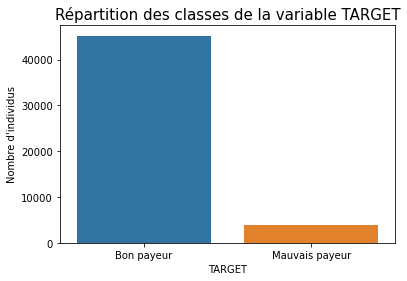

In [215]:
# Vérifions la répartition de la variable cible dans l'échantillon de modélisation avant suréchantillonnage :
graph_repartition(y_train)

In [61]:
# Paramétrage SMOTE
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=random_state, n_jobs=-1)

In [62]:
X_os, y_os = sm.fit_resample(X_train, y_train)
print("Dimensions du jeu de données d'entraînement suréchantillonné : %s" % Counter(y_os))

Dimensions du jeu de données d'entraînement suréchantillonné : Counter({0.0: 45230, 1.0: 45230})


,Individus,% du total
0.00,45230,50.00
1.00,45230,50.00


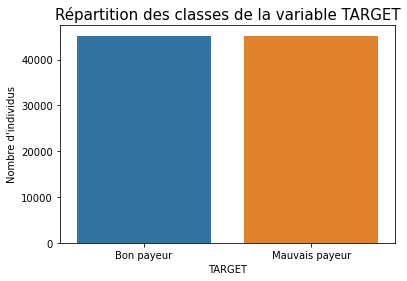

In [65]:
# Vérifions la répartition de la variable cible dans l'échantillon de modélisation après suréchantillonnage :
graph_repartition(y_os)

Les classes sont à présent bien équilibrées.


ICI EXPLICATIONS


In [66]:
# Définissons les modèles sur lesquels tester le suréchantillonnage.
modeles_os = {
            "Dummy Classifier OS" : DummyClassifier(),
            "Random Forest OS" : RandomForestClassifier(
                                                    random_state=random_state,
                                                    n_jobs=-1
                                                    ),
            "LightGBM OS" : LGBMClassifier(
                                        random_state=random_state,
                                        n_jobs=-1
                                       ),
#             "Gradient Boosting OS" : GradientBoostingClassifier()
        }

Dummy Classifier OS
Évaluation du modèle Dummy Classifier OS...
Validation croisée stratifiée du modèle Dummy Classifier OS - Fait(e) en 2s
Entraînement et prédictions du modèle Dummy Classifier OS - Fait(e) en 0s
Meilleur seuil ROC : 1.500000
Meilleur seuil PR : 0.500000


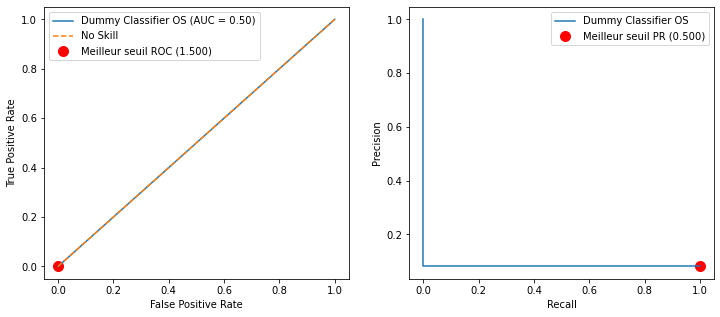

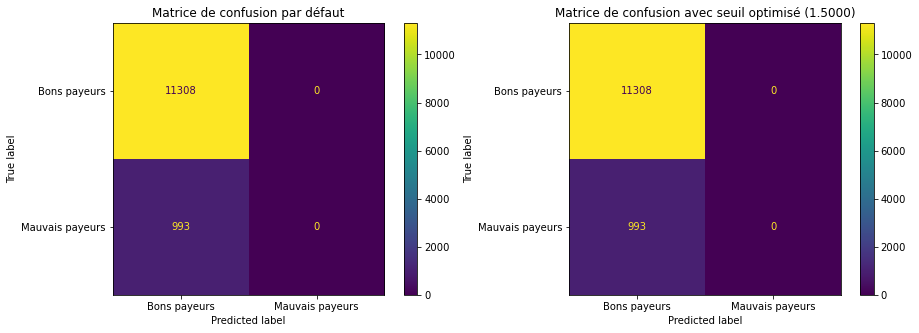

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,Dummy Classifier OS,0.50,0.50,0.00,0.92,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.26,0.03,0.00


Random Forest OS
Évaluation du modèle Random Forest OS...
Validation croisée stratifiée du modèle Random Forest OS - Fait(e) en 91s
Entraînement et prédictions du modèle Random Forest OS - Fait(e) en 24s
Meilleur seuil ROC : 0.200000
Meilleur seuil PR : 0.020000


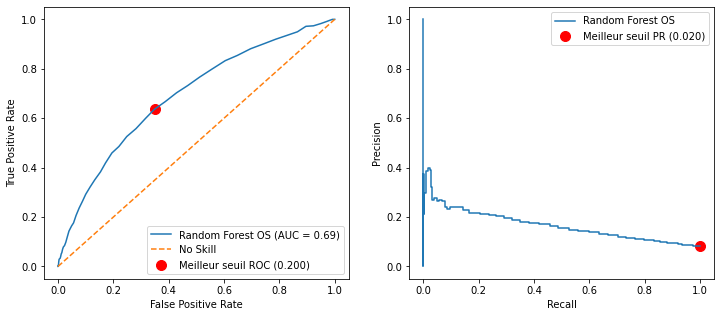

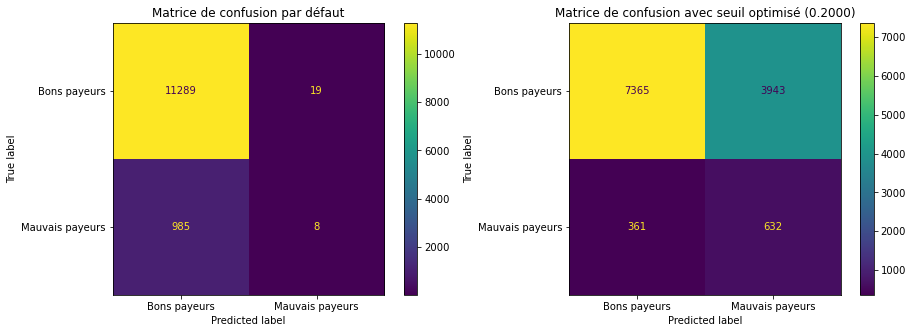

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,Random Forest OS,0.69,0.99,0.00,0.92,0.96,0.00,0.30,1.00,0.00,0.01,0.92,0.00,0.02,0.96,0.00,17.70,0.73,0.41,0.01


LightGBM OS
Évaluation du modèle LightGBM OS...
Validation croisée stratifiée du modèle LightGBM OS - Fait(e) en 59s
Entraînement et prédictions du modèle LightGBM OS - Fait(e) en 11s
Meilleur seuil ROC : 0.083670
Meilleur seuil PR : 0.010880


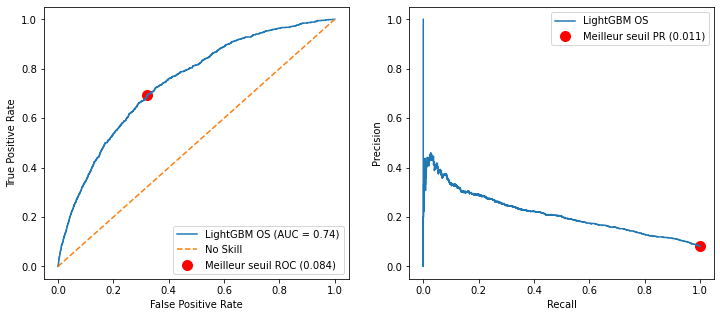

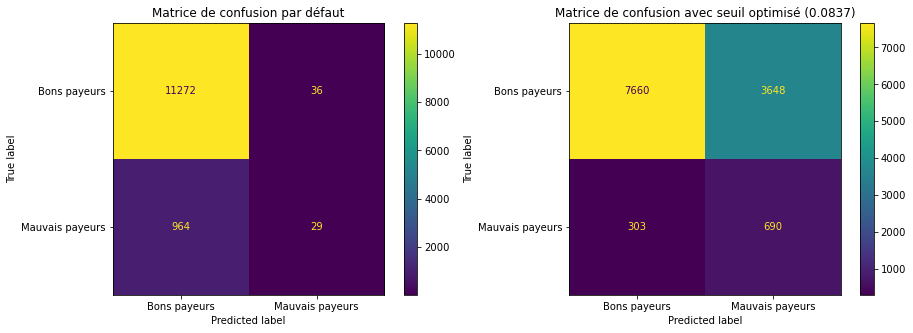

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,LightGBM OS,0.74,0.98,0.00,0.92,0.96,0.00,0.45,1.00,0.00,0.03,0.91,0.00,0.05,0.95,0.00,11.38,1.58,0.35,0.03


In [67]:
for nom_modele, modele in modeles_os.items():
    print(nom_modele)
    pipeline = imbpipeline(steps = [['SMOTE', sm],
                                    ['Classifieur', modele]
                                   ])
    resultats_modele, dict_modele = eval_modele(
                                                pipeline, nom_modele,
                                                X_train, y_train,
                                                X_test, y_test,
                                                skfold, random_state, scoring,
                                                threshold='ROC'
                                                )
    resultats_evaluation = pd.concat([resultats_evaluation, resultats_modele], ignore_index=True)
    liste_modeles.append(dict_modele)

    display(resultats_modele)

Dummy Classifier OS
Évaluation du modèle Dummy Classifier OS...
Validation croisée stratifiée du modèle Dummy Classifier OS - Fait(e) en 2s
Entraînement et prédictions du modèle Dummy Classifier OS - Fait(e) en 0s
Meilleur seuil ROC : 1.500000
Meilleur seuil PR : 0.500000


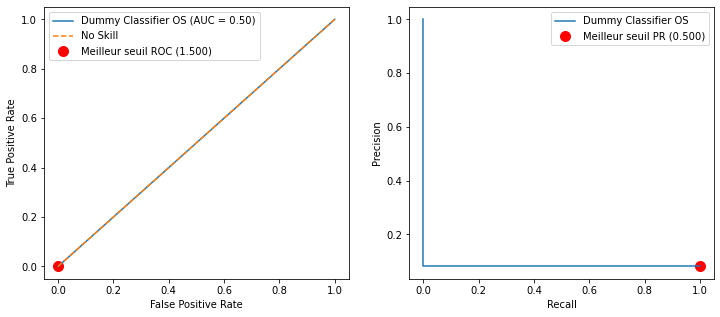

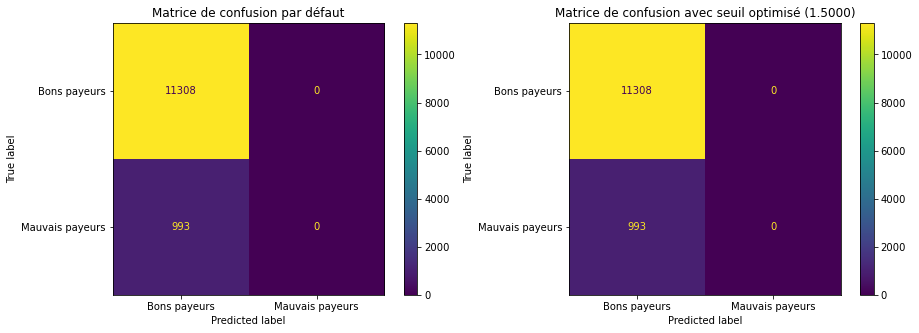

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,Dummy Classifier OS,0.50,0.50,0.00,0.92,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.26,0.03,0.00


Random Forest OS
Évaluation du modèle Random Forest OS...
Validation croisée stratifiée du modèle Random Forest OS - Fait(e) en 91s
Entraînement et prédictions du modèle Random Forest OS - Fait(e) en 24s
Meilleur seuil ROC : 0.200000
Meilleur seuil PR : 0.020000


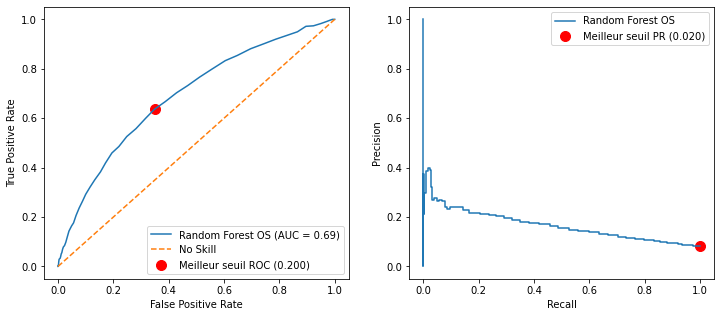

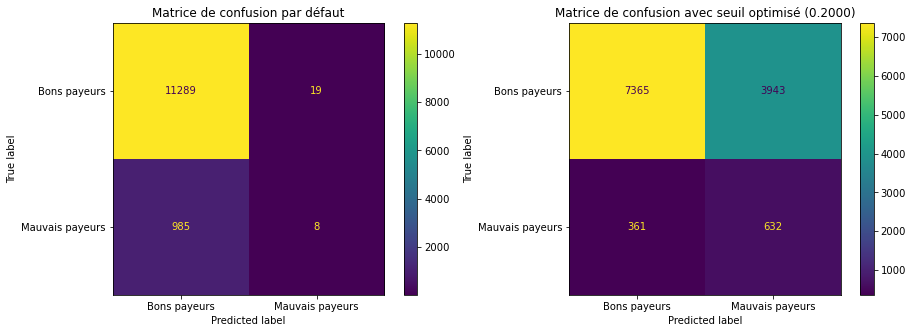

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,Random Forest OS,0.69,0.99,0.00,0.92,0.96,0.00,0.30,1.00,0.00,0.01,0.92,0.00,0.02,0.96,0.00,17.70,0.73,0.41,0.01


LightGBM OS
Évaluation du modèle LightGBM OS...
Validation croisée stratifiée du modèle LightGBM OS - Fait(e) en 59s
Entraînement et prédictions du modèle LightGBM OS - Fait(e) en 11s
Meilleur seuil ROC : 0.083670
Meilleur seuil PR : 0.010880


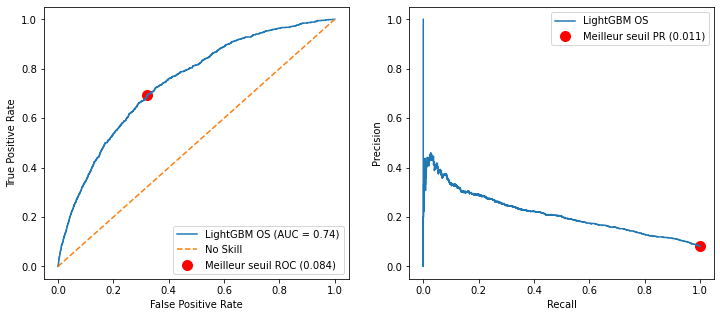

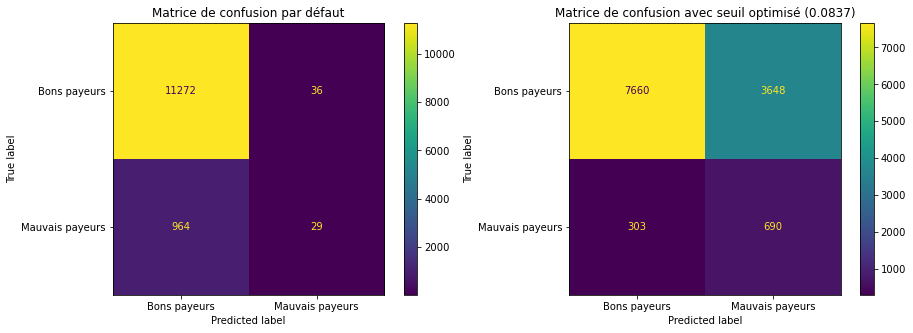

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,LightGBM OS,0.74,0.98,0.00,0.92,0.96,0.00,0.45,1.00,0.00,0.03,0.91,0.00,0.05,0.95,0.00,11.38,1.58,0.35,0.03


In [67]:
# Pour comparaison après correction de l'approche CV SMOTE
# for nom_modele, modele in modeles_os.items():
#     print(nom_modele)
#     pipeline = imbpipeline(steps = [['SMOTE', sm],
#                                     ['Classifieur', modele]
#                                    ])
#     resultats_modele, dict_modele = eval_modele(
#                                                 modele, nom_modele,
#                                                 X_train, y_train,
#                                                 X_test, y_test,
#                                                 skfold, random_state, scoring,
#                                                 threshold='ROC'
#                                                 )
#     resultats_evaluation = pd.concat([resultats_evaluation, resultats_modele], ignore_index=True)
#     liste_modeles.append(dict_modele)
#     display(resultats_modele)

In [68]:
resultats_evaluation

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,Dummy Classifier,0.50,0.50,0.00,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.02,0.01
1,Random Forest,0.71,0.69,0.01,0.92,0.92,0.00,0.00,0.10,0.20,0.00,0.00,0.00,0.00,0.00,0.00,8.99,1.00,0.23,0.01
2,LightGBM,0.77,0.76,0.01,0.92,0.92,0.00,0.45,0.41,0.05,0.02,0.03,0.00,0.05,0.05,0.00,4.62,0.53,0.16,0.04
3,Gradient Boosting,0.76,0.76,0.01,0.92,0.92,0.00,0.61,0.42,0.04,0.02,0.02,0.00,0.04,0.03,0.01,124.67,0.39,0.19,0.00
4,Random Forest balanced,0.73,0.71,0.01,0.92,0.92,0.00,0.00,0.20,0.40,0.00,0.00,0.00,0.00,0.00,0.00,6.49,0.68,0.21,0.01
5,LightGBM balanced,0.76,0.76,0.01,0.78,0.79,0.01,0.20,0.20,0.01,0.57,0.55,0.02,0.29,0.29,0.01,5.48,0.36,0.23,0.01
6,Dummy Classifier OS,0.50,0.50,0.00,0.92,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.26,0.03,0.00
7,Random Forest OS,0.69,0.99,0.00,0.92,0.96,0.00,0.30,1.00,0.00,0.01,0.92,0.00,0.02,0.96,0.00,17.70,0.73,0.41,0.01
8,LightGBM OS,0.74,0.98,0.00,0.92,0.96,0.00,0.45,1.00,0.00,0.03,0.91,0.00,0.05,0.95,0.00,11.38,1.58,0.35,0.03


In [68]:
# Pour comparaison au résultats avec une CV SMOTE correcte (en erreur ici)
#resultats_evaluation

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,Dummy Classifier,0.50,0.50,0.00,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.02,0.01
1,Random Forest,0.71,0.69,0.01,0.92,0.92,0.00,0.00,0.10,0.20,0.00,0.00,0.00,0.00,0.00,0.00,8.99,1.00,0.23,0.01
2,LightGBM,0.77,0.76,0.01,0.92,0.92,0.00,0.45,0.41,0.05,0.02,0.03,0.00,0.05,0.05,0.00,4.62,0.53,0.16,0.04
3,Gradient Boosting,0.76,0.76,0.01,0.92,0.92,0.00,0.61,0.42,0.04,0.02,0.02,0.00,0.04,0.03,0.01,124.67,0.39,0.19,0.00
4,Random Forest balanced,0.73,0.71,0.01,0.92,0.92,0.00,0.00,0.20,0.40,0.00,0.00,0.00,0.00,0.00,0.00,6.49,0.68,0.21,0.01
5,LightGBM balanced,0.76,0.76,0.01,0.78,0.79,0.01,0.20,0.20,0.01,0.57,0.55,0.02,0.29,0.29,0.01,5.48,0.36,0.23,0.01
6,Dummy Classifier OS,0.50,0.50,0.00,0.92,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.26,0.03,0.00
7,Random Forest OS,0.69,0.99,0.00,0.92,0.96,0.00,0.30,1.00,0.00,0.01,0.92,0.00,0.02,0.96,0.00,17.70,0.73,0.41,0.01
8,LightGBM OS,0.74,0.98,0.00,0.92,0.96,0.00,0.45,1.00,0.00,0.03,0.91,0.00,0.05,0.95,0.00,11.38,1.58,0.35,0.03


On observe un overfitting sur la métrique ROC_AUC, sans meilleure capacité de généralisation. La plupart des autres métriques sont améliorées, en dehors du score F1, qui est moins bon dans le cas de lightgbm.

### Sous-échantillonnage
Le sous échantillonnage consisterait à considérer l'intégralité des individus de classe positive (3970 individus en défaut de paiement dans notre échantillon d'entraînement), et autant d'individus de la classe négative (sans incident de paiement). Nous laissons donc de côté 45230 - 3970 = 41260 individus, ce qui risque d'impacter négativement l'entraînement du modèle.
Faute d'intérêt et de temps nous ne testerons donc pas le sous-échantillonnage dans l'immédiat.

## Optimisation des hyperparamètres
Nous allons ici tenter d'optimiser les hyperparamètres des modèles les plus performants jusque là.

In [124]:
modeles_os_ohp = {
                    'Random Forest OS': RandomForestClassifier(n_jobs=-1, random_state=82),
                    'LightGBM OS': LGBMClassifier(random_state=82)
                }

In [125]:
# Observons les paramètres par défauts des modèles
for nom, modele in modeles_os_ohp.items():
    print('\n', nom)
    display(modele.get_params())


 Random Forest OS


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 82,
 'verbose': 0,
 'warm_start': False}


 LightGBM OS


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 82,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### LightGBM
Recherchons les meilleurs hyperparamètres pour le modèle basé sur LightGBM avec une recherche croisée sur grille :

In [156]:
# Paramètres LightGBM trouvés par optimisation Bayesienne (tirés du kernel Kaggle ayant servi de modèle)
param_grid = {
                "colsample_bytree" : [0.9497036, 1], # 1 = Default
                "learning_rate": [0.2], # default : 0.1
                "max_depth": [-1, 8], # default : -1
                "min_child_weight" : [39.3259775], # default : 0.001
                "min_split_gain" : [0.0222415], # default : 0.0
                "n_estimators" : [10000], # default : 100
                #"n_jobs" : [4, 8],
                "num_leaves": [34], # default : 31
                "reg_alpha" : [0.041545473], # default : 0.0
                "reg_lambda": [0.0735294], # 0.0
                "subsample" : [0.8715623], # default : 1
}

In [157]:
gscv = GridSearchCV(
                    LGBMClassifier(random_state=82),
                    param_grid,
                    scoring="roc_auc",
                    cv=skfold,
                    n_jobs=-1
)

In [158]:
gscv_results = gscv.fit(X_os, y_os)

In [159]:
gscv_results.best_score_

0.9801279885757463

In [160]:
gscv_results.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.2,
 'max_depth': -1,
 'min_child_weight': 39.3259775,
 'min_split_gain': 0.0222415,
 'n_estimators': 10000,
 'num_leaves': 34,
 'reg_alpha': 0.041545473,
 'reg_lambda': 0.0735294,
 'subsample': 0.8715623}

In [162]:
gscv.best_estimator_

LGBMClassifier(colsample_bytree=1, learning_rate=0.2,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, num_leaves=34, random_state=82,
               reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

In [163]:
modele = gscv_results.best_estimator_
nom_modele = "LightGBM OS Opt"

Évaluation du modèle LightGBM OS Opt...
Validation croisée stratifiée du modèle LightGBM OS Opt - Fait(e) en 1315s
Entraînement et prédictions du modèle LightGBM OS Opt - Fait(e) en 210s
Meilleur seuil ROC : 0.008261
Meilleur seuil PR : 0.000011


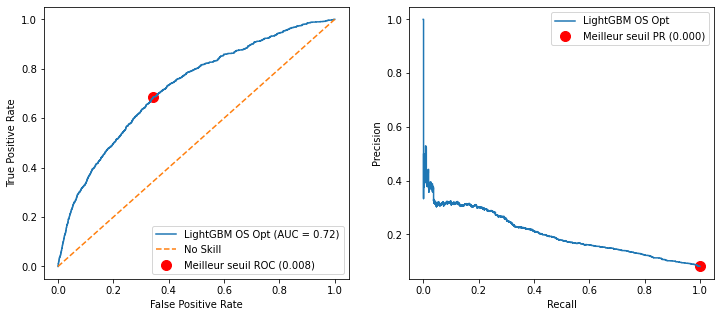

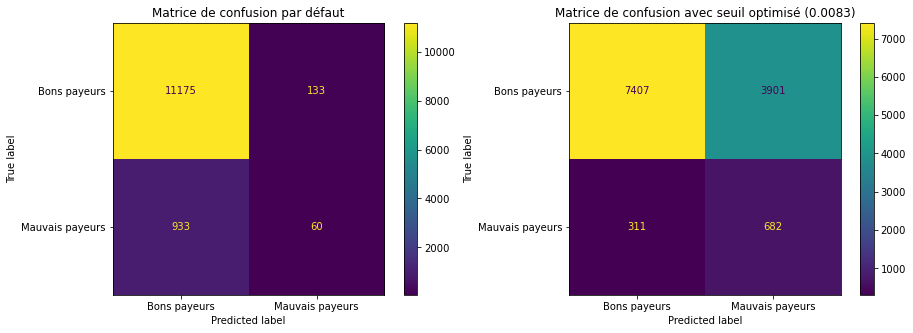

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,LightGBM OS Opt,0.72,0.98,0.00,0.91,0.95,0.00,0.31,0.99,0.00,0.06,0.92,0.00,0.10,0.95,0.00,261.97,56.79,1.03,0.07


In [164]:
# Évaluons le modèle pour le comparer aux précédents
resultats_modele, dict_modele = eval_modele(
                                                modele, nom_modele,
                                                X_os, y_os,
                                                X_test, y_test,
                                                skfold, random_state, scoring
                                                )
resultats_evaluation = pd.concat([resultats_evaluation, resultats_modele], ignore_index=True)
liste_modeles.append(dict_modele)
display(resultats_modele)

In [165]:
# Dressons la liste de toutes les modèles étudiés :
resultats_evaluation

,Modèle,roc_auc,CV roc_auc mean,CV roc_auc std,accuracy,CV accuracy mean,CV accuracy std,precision,CV precision mean,CV precision std,recall,CV recall mean,CV recall std,f1,CV f1 mean,CV f1 std,CV fit_time mean,CV fit_time std,CV score_time mean,CV score_time std
0,Dummy Classifier,0.50,0.50,0.00,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.02,0.01
1,Random Forest,0.71,0.69,0.01,0.92,0.92,0.00,0.00,0.10,0.20,0.00,0.00,0.00,0.00,0.00,0.00,8.99,1.00,0.23,0.01
2,LightGBM,0.77,0.76,0.01,0.92,0.92,0.00,0.45,0.41,0.05,0.02,0.03,0.00,0.05,0.05,0.00,4.62,0.53,0.16,0.04
3,Gradient Boosting,0.76,0.76,0.01,0.92,0.92,0.00,0.61,0.42,0.04,0.02,0.02,0.00,0.04,0.03,0.01,124.67,0.39,0.19,0.00
4,Random Forest balanced,0.73,0.71,0.01,0.92,0.92,0.00,0.00,0.20,0.40,0.00,0.00,0.00,0.00,0.00,0.00,6.49,0.68,0.21,0.01
5,LightGBM balanced,0.76,0.76,0.01,0.78,0.79,0.01,0.20,0.20,0.01,0.57,0.55,0.02,0.29,0.29,0.01,5.48,0.36,0.23,0.01
6,Dummy Classifier OS,0.50,0.50,0.00,0.92,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.26,0.03,0.00
7,Random Forest OS,0.69,0.99,0.00,0.92,0.96,0.00,0.30,1.00,0.00,0.01,0.92,0.00,0.02,0.96,0.00,17.70,0.73,0.41,0.01
8,LightGBM OS,0.74,0.98,0.00,0.92,0.96,0.00,0.45,1.00,0.00,0.03,0.91,0.00,0.05,0.95,0.00,11.38,1.58,0.35,0.03
9,LightGBM OS Opt,0.72,0.98,0.00,0.91,0.95,0.00,0.31,0.99,0.00,0.06,0.92,0.00,0.10,0.95,0.00,261.97,56.79,1.03,0.07


## Interprétabilité du modèle
Nous nous intéressons ici à l'interprétabilité globale du modèle en observant le poids que le modèle à déterminé pour chaque variable lors de son entraînement.

In [167]:
# Fixons le modèle choisi au cours des évaluations précédentes :
# (LightGBM sur le jeu de données d'entraînement suréchantillonné et avec les hyperparamètres optimisés)
modele_choisi = liste_modeles[9]['modele']

In [168]:
df_fi = pd.DataFrame({
                    "feature name":modele_choisi.feature_name_,
                    "feature importance":modele_choisi.feature_importances_
                     })

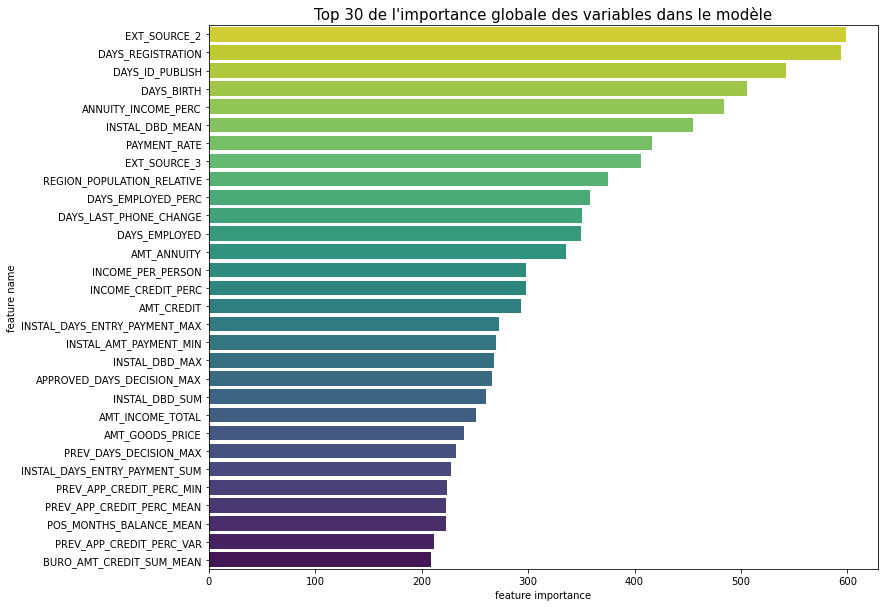

In [169]:
nb_var = 30
plt.figure(figsize=(12, 10))
sns.barplot(x="feature importance",
            y="feature name",
            data=df_fi.sort_values(by='feature importance', ascending=False).head(nb_var),
            palette='viridis_r'
           )
plt.title(f"Top {nb_var} de l'importance globale des variables dans le modèle", fontsize=15)
plt.show()

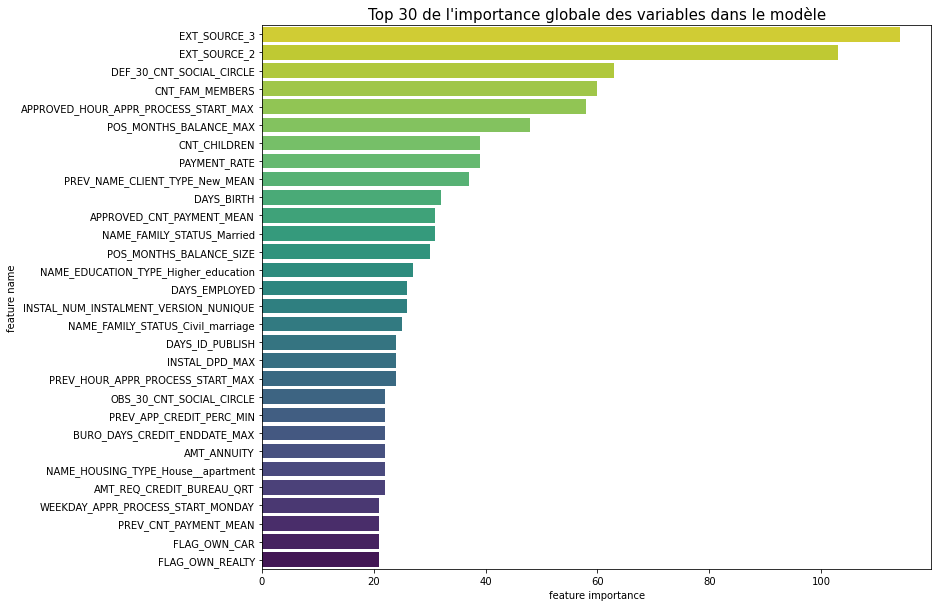

In [102]:
# Données pour comparaison - Feature Importance du modèle LightGBM par défaut.
# L'importance des variables et leur poids a changé.
#
# nb_var = 30
# plt.figure(figsize=(12, 10))
# sns.barplot(x="feature importance",
#             y="feature name",
#             data=df_fi.sort_values(by='feature importance', ascending=False).head(nb_var),
#             palette='viridis_r'
#            )
# plt.title(f"Top {nb_var} de l'importance globale des variables dans le modèle", fontsize=15)
# plt.show()

## Entraînement final et sauvegarde

### Modèle

In [170]:
# Utilisation du modèle lightgbm tel qu'entraîné sur le jeu de données sur-échantillonné
# avec des hyperparamètres optimisés :
liste_modeles[9]

{'nom_modele': 'LightGBM OS Opt',
 'modele': LGBMClassifier(colsample_bytree=1, learning_rate=0.2,
                min_child_weight=39.3259775, min_split_gain=0.0222415,
                n_estimators=10000, num_leaves=34, random_state=82,
                reg_alpha=0.041545473, reg_lambda=0.0735294,
                subsample=0.8715623),
 'y_pred': array([0., 0., 0., ..., 0., 0., 0.]),
 'y_proba': array([0.00183508, 0.00050379, 0.03434255, ..., 0.00040058, 0.0021201 ,
        0.00010207]),
 'y_pred_threshold': array([0, 0, 1, ..., 0, 0, 0]),
 'roc_auc': 0.7235222966852154,
 'seuil ROC': 0.00826078173759799,
 'seuil PR': 1.0607826384474809e-05}

In [171]:
# Export du modèle au format joblib :
joblib.dump(liste_modeles[9]['modele'], os.path.join(data_dir, modele_prod))

['.data/modele_api.joblib']

### Données API
#### Échantillonnage
Nous allons créer un échantillon de 10 000 individus de notre jeu de données d'entraînement initial pour pouvoir tester l'API et le tableau de bord.

In [172]:
X_api = X.sample(n=10000, random_state=random_state)

In [173]:
y_api = y[X_api.index]

,Individus,% du total
0.00,9212,92.12
1.00,788,7.88


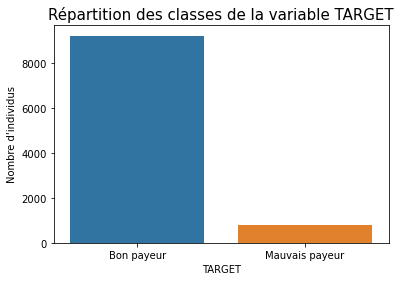

In [176]:
# Vérifions la répartition de la variable cible dans l'échantillon :
graph_repartition(y_api)

Les classes de la variable cible sont réparties selon les bonnes proportions.

#### Classement par  SK_ID_CURR
Afin d'améliorer l'affichage de la liste des numéros de dossier client (SK_ID_CURR) lors de l'affichage par le tableau de bord, classons le DataFrame par `SK_ID_CURR` croissant avant sa sauvegarde. Sans cette action, les numéros de dossier seront affichés dans le désordre par la liste déroulante du tableau de bord qui présente les dossiers consultables.

In [248]:
# Réintégrons certaines variables dans le DataFrame destiné à l'API pour pouvoir les fournirau tableau de bord:
# - SK_ID_CURR pour l'affichage du numéro de dossier.
# - TARGET pour l'affichage des différentes classes de la variable à prédire dans les graphiques.
X_api[['SK_ID_CURR', 'TARGET']] = df_fraction[['SK_ID_CURR', 'TARGET']]

In [250]:
# Classement du DataFrame par SK_ID_CURR croissant:
X_api.sort_values(by='SK_ID_CURR', inplace=True)

In [251]:
# Sauvegardons l'échantillon à destination de l'API :
X_api.reset_index(drop=True).to_feather(os.path.join(data_dir, donnees_prod))

### Données tableau de board
À partir des données sélectionnées pour le fonctionnement de l'API, nous préparons ici un jeu de données pour le test du tableau de bord. En effet, nous souhaitons avoir dès à présent une liste des individus prédits comme étant en défaut, de façon à ne pas avoir à chercher au hasard les 8% d'individus potentiellement en défaut.
Cette liste nous permettra de pouvoir tester facilement les deux cas de prédictions possibles (en défaut ou non) au niveau du rendu du tableau de bord.

In [237]:
# Prédiction des individus en défaut de paiement pour pouvoir les utiliser lors du test du tableau de bord :
# (sans SK_ID_CURR)
y_pred_api = modele_choisi.predict(X_api[var_predictives])

In [238]:
df_api = X_api.copy()

In [240]:
# Ajout des prédictions
df_api['TARGET_pred'] = y_pred_api

In [242]:
# Sélection des clients en défaut uniquement
clients_predits_en_defaut = df_api[df_api['TARGET_pred']==1]

In [243]:
clients_predits_en_defaut.shape

(659, 545)

In [244]:
# Affichage d'un échantillon de 10 individus en defaut :
df_api.loc[df_api['TARGET_pred']==1, ['SK_ID_CURR','TARGET','TARGET_pred']].sample(n=10)

,SK_ID_CURR,TARGET,TARGET_pred
279029,423269,1.00,1.00
224946,360560,1.00,1.00
307000,455684,1.00,1.00
123503,243227,1.00,1.00
47894,155471,1.00,1.00
220230,355134,1.00,1.00
64791,175140,1.00,1.00
201275,333310,1.00,1.00
296739,443800,1.00,1.00
135873,257603,1.00,1.00


In [245]:
# Affichage de 10 individus en defaut en les classant par SK_ID_CURR croissant :
clients_predits_en_defaut[['SK_ID_CURR','TARGET','TARGET_pred']].head(10)

,SK_ID_CURR,TARGET,TARGET_pred
235,100273,1.00,1.00
534,100616,1.00,1.00
2489,102903,1.00,1.00
3034,103543,1.00,1.00
3557,104157,1.00,1.00
4105,104800,1.00,1.00
4824,105639,1.00,1.00
5089,105946,1.00,1.00
5622,106578,1.00,1.00
7473,108714,1.00,1.00


In [246]:
# Sauvegarde de la liste des clients prédits en défaut pour éventuelle consultation ultérieure :
clients_predits_en_defaut.reset_index(drop=True).to_feather(os.path.join(data_dir, clients_pred_defaut))